# Gaussian Mixture Models
Justin Dano

1. Getting the data
2. Calibrating initial paramters
3. Expectation Step
4. Maximization Step
5. Stopping Criteria
6. Visualization
7. Entire GMM algorithm


Each step for the first iteration of the GMM is explained with an example. Then the full EM procedure is ran using a stopping criteria and displaying the final parameters at the end. 

In [1]:
import pandas as pd
from scipy.stats import norm, multivariate_normal
import numpy as np
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as pyplot

# Some configuration
mpl.style.use('seaborn')
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

## 1. Getting the data

The .mat files have been downloaded and converted to .csv 

In [2]:
def get_data():
    data = pd.read_csv('hw3_1.csv', header=None).transpose()
    return data

data = get_data()

In [3]:
data.head()

,0,1
0,-0.072801,-0.99431
1,1.052600,0.42878
2,0.988350,-0.59902
3,1.886100,-0.21998
4,0.645040,-1.30990


In [4]:
data.shape

(100, 2)

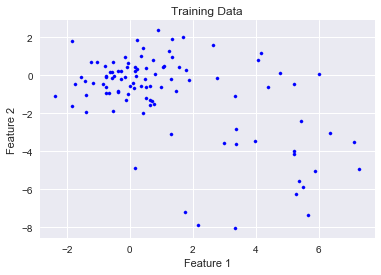

In [5]:
fig = pyplot.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(data.values[:,0], data.values[:,1], s=10, c='b', marker="o")
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('Training Data')
pyplot.show()

## 2. Calibrating Initial Parameters

In [6]:
def calc_cov_matrix(sample_vectors, mean_vector):
    """
    Params:
        sample_vector - list of Vectors ( n x 1 )
        mean_vector   - mean for each n ( n x 1 )
    Returns
        scatter_matrix - Matrix ( n x n )
    """
    return reduce(lambda x, y: x+y, [np.outer(sample_vector - mean_vector, sample_vector - mean_vector) for sample_vector in sample_vectors]) / len(sample_vectors)


def calc_mean_vector(sample_vectors):
    """
    :param sample_vectors: list of np.array [ ( n x 1 ), ( n x 1 ), .., ( n x 1 ) ]
    :return: np.array - mean vector ( n x 1 )
    """
    # np.stack transforms the list into a multi-dimensional numpy array
    return np.stack(sample_vectors, axis=1).mean(axis=1)

In [7]:
# Split the data
g1 = data[:50].values
g2 = data[50:].values
# Get initial parameters
u1 = calc_mean_vector(g1)
c1 = calc_cov_matrix(g1, u1)
u2 = calc_mean_vector(g2)
c2 = calc_cov_matrix(g2, u2)

In [8]:
print('First Gaussian')
print('Mean Vector: {}'.format(u1))
print('Covariance matrix: {}'.format(list(c1)))

print('\nSecond Gaussian')
print('Mean Vector: {}'.format(u2))
print('Covariance matrix: {}'.format(list(c2)))

First Gaussian
Mean Vector: [0.566 -0.622]
Covariance matrix: [array([3.312, -0.948]), array([-0.948, 2.245])]

Second Gaussian
Mean Vector: [1.907 -1.408]
Covariance matrix: [array([6.358, -3.796]), array([-3.796, 7.380])]


Now we will wrap these methods into 1 function and return the starting distributions

In [9]:
def get_base_distributions(data):
    g1 = data[:50].values
    g2 = data[50:].values

    # MLE Parameters are the sample mean and sample covariance
    u1 = calc_mean_vector(g1)
    c1 = calc_cov_matrix(g1, u1)

    u2 = calc_mean_vector(g2)
    c2 = calc_cov_matrix(g2, u2)

    gauss1 = multivariate_normal(u1, c1)
    gauss2 = multivariate_normal(u2, c2)
    return gauss1, gauss2

In [10]:
gauss1, gauss2 = get_base_distributions(data)

## 3. Expectation Step

We can now compute the likelihood for each sample indenpendently to determine which Gaussian it should belong to.

![Expectation](latex/exp_step3.PNG "E-Step")

For each sample, we compute the likelihood, multiplied by the weight of that gaussian. Then we normalize across both likelihoods so they sum to 1

r - is our responsibilities matrix that contains the likelihood for the gaussians based on each sample <br /> 
K - number of Gaussians (our case K=2) <br />
k - a particular gaussian (column) <br />
i - sample (row) <br />


In [11]:
def calc_expectation(data, gauss1, gauss2, pi):
    # E Step
    r = np.zeros((len(data), 2))
    for c, g, p in zip(range(2), [gauss1, gauss2], pi):
        r[:, c] = p * g.pdf(data)

    for i in range(len(r)):
        r[i] = r[i] / np.sum(r, axis=1)[i]

    # r is a matrix with a probability for each cluster (rows sum to 1)
    return r

In [12]:
rho = [0.5, 0.5]
r = calc_expectation(data, gauss1, gauss2, rho)

Here are the first 5 samples (each sample has 2 features)

In [13]:
data[:5].values

array([[-0.073, -0.994],
       [1.053, 0.429],
       [0.988, -0.599],
       [1.886, -0.220],
       [0.645, -1.310]])

And here is the likelihood for each row to go to either the first Gaussian or Second

In [14]:
r[:5]

array([[0.737, 0.263],
       [0.654, 0.346],
       [0.699, 0.301],
       [0.627, 0.373],
       [0.702, 0.298]])

In [15]:
r.shape

(100, 2)

## 4. Maximization Step

We need to re-calibrate the parameters for our two gaussians

### 4.1 - Rho (Gaussian Weight)

![RhoUpdate](latex/max_rho.PNG "M-Step")

In [16]:
def calc_total_weight(r):
    return r.sum(axis=0)

def calc_mixture(total_weight):
    # Parameter 1 (rho) Gaussian Mixture weighting
    return total_weight / total_weight.sum()

total_weight = calc_total_weight(r)
rho_u = calc_mixture(total_weight)

In [17]:
total_weight

array([53.518, 46.482])

In [18]:
print('Original weighting: {}'.format(rho))
print('Updated  weighting: {}'.format(rho_u))

Original weighting: [0.5, 0.5]
Updated  weighting: [0.535 0.465]


### 4.2 - Mean vectors

![MaxMean](latex/max_mean.PNG "M-Step")

In [19]:
def calc_updated_mean(data, r, total_weight):
    """
    Calculate the updated mean

    Since our training sample has two features, we need to perform broadcast multiplication which
    will loop through each cluster vector in r and apply scalar multiplication to all samples for
    both features.
    :param data:     pd.DataFrame (n * 2) - training samples
    :param r:            np.array (n * 2) - our responsibility for each sample
    :param total_weight: np.array (1 * 2) - accumulation of responsibility for each cluster
    :return:     list of np.array (1 * 2) - mean vectors for each Gaussian  
    """
    mu_c = []
    for cluster, rho in zip(r.T, total_weight):
        mu_c.append((np.sum(data.multiply(cluster, axis=0)) / rho).values)
    return mu_c


mu_u = calc_updated_mean(data, r, total_weight)

In [20]:
print('First Gaussian')
print('Original Mean Vector: {}'.format(u1))
print('Updated  Mean Vector: {}'.format(mu_u[0]))
print('\nSecond Gaussian')
print('Original Mean Vector: {}'.format(u2))
print('Updated  Mean Vector: {}'.format(mu_u[1]))

First Gaussian
Original Mean Vector: [0.566 -0.622]
Updated  Mean Vector: [0.244 -0.278]

Second Gaussian
Original Mean Vector: [1.907 -1.408]
Updated  Mean Vector: [2.379 -1.865]


### 4.3 - Covariance Matrices 

![MaxCov](latex/max_cov.PNG "M-Step")

In [21]:
def calc_updated_cov(data, r, mu_u, total_weight):
    """
    Calculate the updated covariance
    
    For each cluster, we calculate the covariance matrix while also multiplying by each samples responsibility

    :param data:     pd.DataFrame (n * 2) - training samples
    :param r:            np.array (n * 2) - our responsibility for each sample
    :param mu_u: list of np.array (1 * 2) - mean vectors for each Gaussian
    :param total_weight: np.array (1 * 2) - accumulation of responsibility for each cluster
    :return:     list of np.array (2 * 2) - covariance matrix for each Gaussian
    """
    d = data.values
    cov_c = []
    for cluster, u, w in zip(r.T, mu_u, total_weight):
        s = 0
        for n in range(len(d)):
            s += cluster[n]*np.outer(d[n] - u, d[n] - u)
        cov_c.append(s / w)
    return cov_c

cov_u = calc_updated_cov(data, r, mu_u, total_weight)

In [22]:
print('First Gaussian')
print('Original Covariance matrix: {}'.format(list(c1)))
print('Updated  Covariance matrix: {}'.format(list(cov_u[0])))
print('\nSecond Gaussian')
print('Original Covariance matrix: {}'.format(list(c2)))
print('Updated  Covariance matrix: {}'.format(list(cov_u[1])))

First Gaussian
Original Covariance matrix: [array([3.312, -0.948]), array([-0.948, 2.245])]
Updated  Covariance matrix: [array([1.993, -0.154]), array([-0.154, 1.182])]

Second Gaussian
Original Covariance matrix: [array([6.358, -3.796]), array([-3.796, 7.380])]
Updated  Covariance matrix: [array([6.636, -3.679]), array([-3.679, 7.977])]


Putting everything together, the maximization step can be wrapped into a function.

In [23]:
def calc_maximization(data, r):
    """
    Calculates the updated parameters based on our responsibility matrix
    :param data: pd.DataFrame (n * 2) - training samples
    :param r:        np.array (n * 2) - our responsibility for each sample
    :return: list of numpy.arrays
    """
    total_weight = calc_total_weight(r)
    rho_u = calc_mixture(total_weight)
    mu_u = calc_updated_mean(data, r, total_weight)
    cov_u = calc_updated_cov(data, r, mu_u, total_weight)
    return rho_u, mu_u, cov_u

In [24]:
rho

[0.5, 0.5]

# 5. Stopping Criteria - Log-Likelihood 

![LLhood](latex/log_likelihood.PNG "Log Likelihood")

In [25]:
def evaluate_log_likelihood(data, gauss1, gauss2, rho_u):
    """
    Computes the log-likelihood 
    :param data: pd.DataFrame (n * 2) - training samples
    :param gauss1: scipy.stats._multivariate_normal
    :param gauss2: scipy.stats._multivariate_normal
    :param rho_u: list [float, float] - Gaussian Weights 
    :return: float
    """
    r_new = np.zeros((len(data), 3))
    for c, g, p in zip(range(2), [gauss1, gauss2], rho_u):
        r_new[:, c] = p * g.pdf(data)

    r_new[:, 2] = np.log(r_new[:, 0] + r_new[:, 1])
    log_likelihood = r_new[:, 2].sum()
    return log_likelihood

l_hood = evaluate_log_likelihood(data, gauss1, gauss2, rho)

In [26]:
l_hood

-418.31335205425876

# 6. Visualization of GMM 

In [30]:
def plot_gmm(data, XY, gauss1, gauss2, title):
    d = data.values
    fig = pyplot.figure(figsize=(10, 10))
    ax0 = fig.add_subplot(111)
    ax0.scatter(d[:, 0], d[:, 1])
    ax0.set_title(title)
    ax0.set_xlabel('Feature 1')
    ax0.set_ylabel('Feature 2')
    ax0.contour(np.sort(d[:, 0]),
                np.sort(d[:, 1]),
                gauss1.pdf(XY).reshape(len(d), len(d)),
                colors='black',
                alpha=0.3)
    ax0.contour(np.sort(d[:, 0]),
                np.sort(d[:, 1]),
                gauss2.pdf(XY).reshape(len(d), len(d)),
                colors='black',
                alpha=0.3)
    pyplot.show()

def get_contour_grid_points(data):
    # Used for plotting the GMM
    d = data.values
    x, y = np.meshgrid(np.sort(d[:, 0]), np.sort(d[:, 1]))
    XY = np.array([x.flatten(), y.flatten()]).T
    return XY

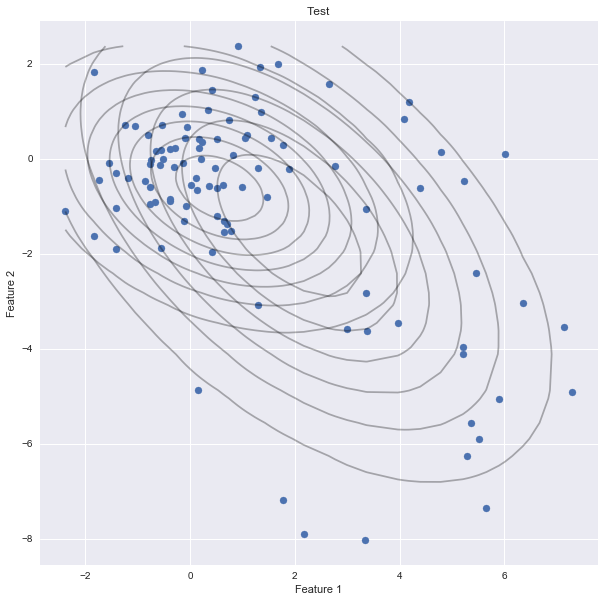

In [31]:
XY = get_contour_grid_points(data)
plot_gmm(data, XY, gauss1, gauss2, 'Test')

# 7. EM Algorithm 

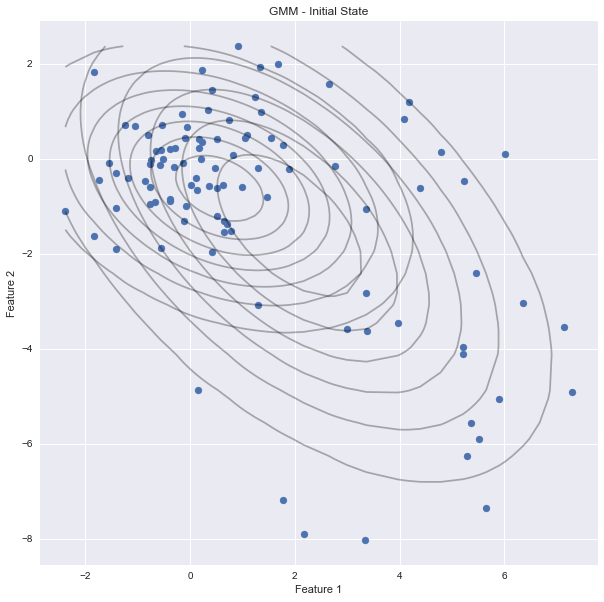

Log-Likelihood
01: Original: -418.313 Updated: -398.786, Difference: 19.527
02: Original: -398.786 Updated: -384.531, Difference: 14.255
03: Original: -384.531 Updated: -381.168, Difference: 3.363
04: Original: -381.168 Updated: -380.457, Difference: 0.711
05: Original: -380.457 Updated: -380.029, Difference: 0.428
06: Original: -380.029 Updated: -379.665, Difference: 0.364
07: Original: -379.665 Updated: -379.374, Difference: 0.291
08: Original: -379.374 Updated: -379.170, Difference: 0.204
09: Original: -379.170 Updated: -379.045, Difference: 0.125
10: Original: -379.045 Updated: -378.977, Difference: 0.068
11: Original: -378.977 Updated: -378.944, Difference: 0.033
12: Original: -378.944 Updated: -378.928, Difference: 0.015
13: Original: -378.928 Updated: -378.922, Difference: 0.007
14: Original: -378.922 Updated: -378.919, Difference: 0.003
15: Original: -378.919 Updated: -378.918, Difference: 0.001
16: Original: -378.918 Updated: -378.918, Difference: 0.000

Final Parameters:
rho:

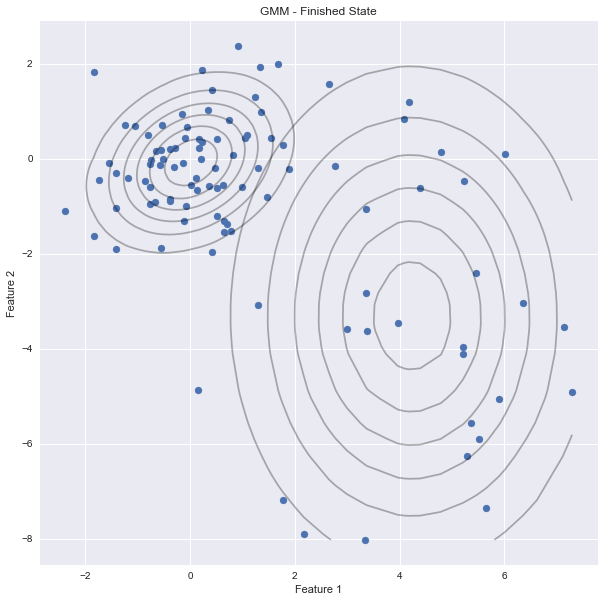

In [32]:
def em_for_mixed_gaussian(data, rho, epis, gmm_plot_data):
    """
    Compute paramters of GMM using the EM algorithm with log likelihood stopping criteria 
    :param data: pd.DataFrame (n * 2)         - training samples
    :param rho: list [float, float]           - gaussian Weights
    :param epis: float                        - threshold for stopping criteria
    :param gmm_plot_data: np.array ( n*n, 2 ) - for plotting the GMM
    """
    # Step 1, calculate initial parameters using subset of data
    gauss1, gauss2 = get_base_distributions(data)

    # Plot Starting Gaussians
    plot_gmm(data, gmm_plot_data, gauss1, gauss2, 'GMM - Initial State')

    # Log Likelihood
    l_hood = evaluate_log_likelihood(data, gauss1, gauss2, rho)

    # Difference in Log Likelihood from two iterations
    d_hood = np.inf

    iteration = 1
    print('Log-Likelihood')
    while d_hood > epis:

        # Step 2, perform Expectation step
        r = calc_expectation(data, gauss1, gauss2, rho)

        # Step 3, perform Maximization step
        rho, mu_u, cov_u = calc_maximization(data, r)

        # Step 4 Check for convergence
        gauss1 = multivariate_normal(mu_u[0], cov_u[0])
        gauss2 = multivariate_normal(mu_u[1], cov_u[1])

        u_hood = evaluate_log_likelihood(data, gauss1, gauss2, rho)
        d_hood = np.abs(l_hood - u_hood)
        print('{0:02d}: Original: {1:0.3f} Updated: {2:0.03f}, Difference: {3:0.03f}'.format(iteration, l_hood, u_hood, d_hood))
        l_hood = u_hood
        iteration += 1

    print('\nFinal Parameters:')
    print('rho: {}'.format(rho))
    print('M1 - Mean: {}'.format(mu_u[0]))
    print('M2 - Mean: {}'.format(mu_u[1]))
    print('M1 - Covariance: {}'.format(list(cov_u[0])))
    print('M2 - Covariance: {}'.format(list(cov_u[1])))

    # Plot Finished GMM
    plot_gmm(data, gmm_plot_data, gauss1, gauss2, 'GMM - Finished State')


data = get_data()
rho = [0.5, 0.5]
epis = .001  # Stopping Threshold
XY = get_contour_grid_points(data)
em_for_mixed_gaussian(data, rho, epis, XY)

### References:
* Lecture notes from Dr. Hong Man (Stevens CPE646 Spring2019)
* https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php
* https://mas-dse.github.io/DSE210/Additional%20Materials/gmm.pdf